In [4]:
import numpy  as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
RAND_SEED=1

      phase speed      phase
Mean    -0.000003 -10.174578
Std      0.013941   3.978187
Var      0.000194  15.825972


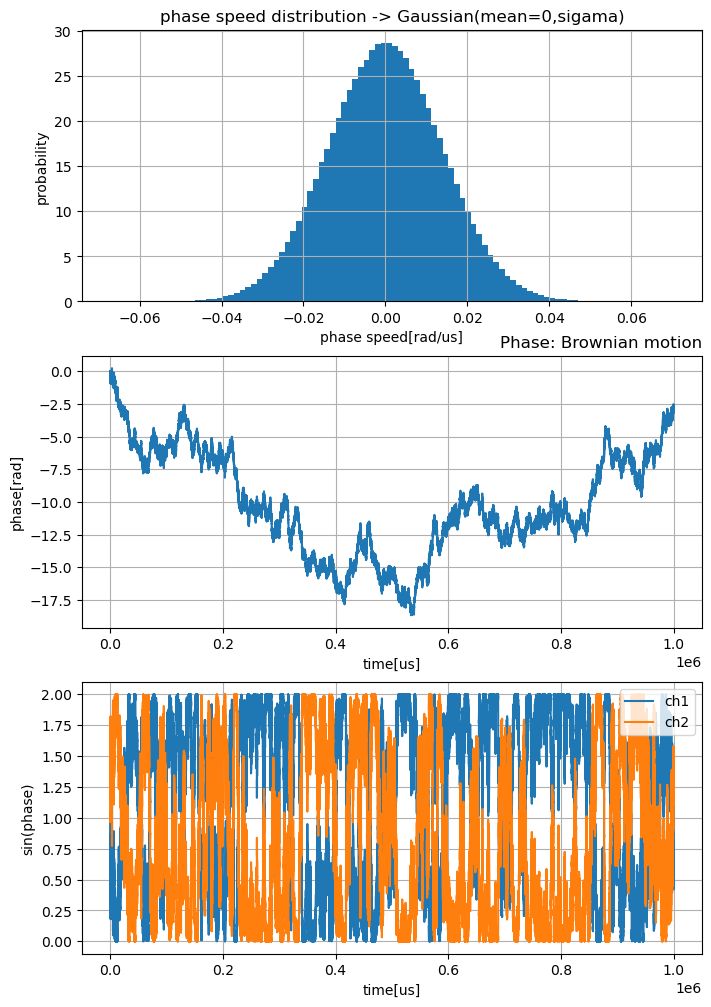

In [5]:
GAMMY=1.0

def get_sig_from_speed(phase_speed,channel):
    phase=np.cumsum(phase_speed)
    #phase*=np.pi/180
    if channel==1:
        return SIG_AMP*(GAMMY+np.sin(phase))
    elif channel==2:
        return SIG_AMP*(GAMMY-np.sin(phase))
def get_sig_from_phase(phase,channel):
    #phase*=np.pi/180
    if channel==1:
        return SIG_AMP*(GAMMY+np.sin(phase))
    elif channel==2:
        return SIG_AMP*(GAMMY-np.sin(phase))

PHASE_SEEPD=0.8/180*np.pi #rad/us
SIG_AMP=1 # 10sample/us  cps=10M
time_axis=np.arange(0,1e6,1) #1us分辨率，len=1s  SR=1M
rng=np.random.default_rng(RAND_SEED)
phase_speed=rng.normal(0,PHASE_SEEPD,time_axis.shape)
phase_speed[0]=0
phase=np.cumsum(phase_speed)
sig_ch1=get_sig_from_speed(phase_speed,1)
sig_ch2=get_sig_from_speed(phase_speed,2)
plt.figure(figsize=(8,12))
plt.subplot(3,1,1)
plt.hist(phase_speed,bins=100,density=True)
plt.ylabel('probability')
plt.xlabel('phase speed[rad/us]')
plt.title('phase speed distribution -> Gaussian(mean=0,sigama)')
plt.grid()
plt.subplot(3,1,2)
plt.plot(time_axis,phase)
plt.xlabel('time[us]')
plt.ylabel('phase[rad]')
plt.title('Phase: Brownian motion',loc='right')
plt.grid()
plt.subplot(3,1,3)
plt.plot(time_axis,sig_ch1,label='ch1')
plt.plot(time_axis,sig_ch2,label='ch2')
plt.xlabel('time[us]')
plt.ylabel('sin(phase)')
plt.grid()
plt.legend(loc=1)
#plt.xlim(0,100000)

df=pd.DataFrame({'Mean':phase_speed.mean(),'Std':phase_speed.std(),'Var':phase_speed.var()},index=['phase speed']).T
def push_data(data,name):
    df[name]=[data.mean(),data.std(),data.var()]
    print(df)
push_data(phase,'phase')

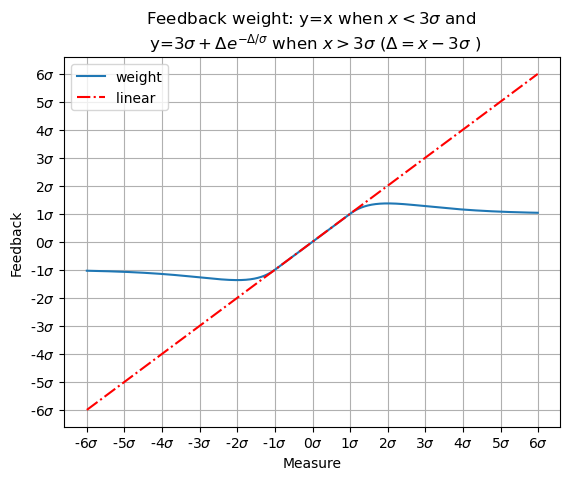

In [6]:
def get_phase_from_count(ch1,ch2):
    if ch1+ch2==0:
        return 0
    else:
        return np.arcsin((ch1-ch2)/(ch1+ch2))

def measure_count(sig,method):
    """method=0:测量返回测量时间内最后一个时刻的phase;  
    method=1:测量时间内的phase的积分;  
    method=2:测量时间内的phase的积分，并引入shot noise;"""
    if method==0:
        return sig[-1]
    elif method==1:
        return sig.sum()
    elif method==2:
        return rng.poisson(sig.sum())
    
def fb_weight(measure, time_exposure,sigma=1):
    phase_speed_in_measure=np.sqrt(time_exposure)*PHASE_SEEPD #sigma
    threshold=sigma*phase_speed_in_measure #1 sigma
    weight=lambda x: np.sign(x) *(threshold + (np.abs(x) - threshold)*np.exp(- (np.abs(x) - threshold)/phase_speed_in_measure))
    mask = np.abs(measure) > threshold
    measure_filtered = np.where(mask, weight(measure),measure)
    return measure_filtered
time_exposure=2
phase_speed_in_measure=np.sqrt(time_exposure)*PHASE_SEEPD #sigma
x=np.arange(-2,2,1/256)*3*phase_speed_in_measure
plt.plot(x,fb_weight(x,time_exposure=time_exposure),label='weight')
plt.plot(x,x,'r-.',label='linear ')
plt.legend()
plt.grid()
plt.xticks(np.arange(-6,7,1)*1*phase_speed_in_measure,['{}$\\sigma$'.format(i*1) for i in np.arange(-6,7,1)])
plt.yticks(np.arange(-6,7,1)*1*phase_speed_in_measure,['{}$\\sigma$'.format(i*1) for i in np.arange(-6,7,1)])
plt.xlabel('Measure')
plt.ylabel('Feedback')
plt.title('Feedback weight: y=x when $x<3\\sigma$ and \n y=3$\\sigma+\\Delta e^{-\\Delta/\\sigma}$ when $x>3\\sigma$ ($\\Delta =x-3\\sigma$ )')
plt.show()

In [7]:
def simu_phase(phase_speed,time_exposure,method):
    """
    method 1: instant feedback  
    method 2: average feedback  
    method 3: average feedback with iteration  
    method 4: weighted feedback  
    """
    
    time_iter1=10 # method 3 迭代参数，每隔time_iter1个exposure再进行一次测量
    
    phase_speed_M=np.copy(phase_speed.reshape((-1,time_exposure)))
    phase_M=np.zeros_like(phase_speed_M)
    sig_ch1_exposure=np.zeros_like(phase_speed_M)
    sig_ch2_exposure=np.zeros_like(phase_speed_M)
    phase_measure_M=np.zeros(phase_speed_M.shape[0]) # 测量出的反馈量
    rng=np.random.default_rng(RAND_SEED)
    phase_offest=0
    
    for i in tqdm(range(sig_ch1_exposure.shape[0])):
        phase_M[i]=np.cumsum(phase_speed_M[i])+phase_offest
        sig_ch1_exposure[i]=get_sig_from_phase(phase_M[i],1)
        sig_ch2_exposure[i]=get_sig_from_phase(phase_M[i],2)
        ###引入shot noise
        ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())#+rng.poisson(1)-1  # shot noise 应该于计数有关
        ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())#+rng.poisson(1)-1
        phase_measure_M[i]=get_phase_from_count(ch1_measure,ch2_measure)
        
        
        if i<(sig_ch1_exposure.shape[0]-1):
            if method==1:
                phase_speed_M[i+1,0]-=phase_measure_M[i] # 反馈到下一个exposure的起始点
            if method==2 or method==3:
                c0=phase_measure_M[i]
                phase_fb_M=np.sign(phase_measure_M[i])*np.abs(c0)
                phase_speed_M[i+1]-=phase_fb_M/time_exposure # 均匀反馈到下一个exposure时间
            if method==4:
                c0=fb_weight(phase_measure_M[i],time_exposure)
                phase_fb_M=np.sign(phase_measure_M[i])*np.abs(c0)
                phase_speed_M[i+1,0]-=phase_fb_M # 均匀反馈到下一个exposure时间

        if method==3:
            if i%time_iter1==0 and i!=0:
                ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter1:i].sum())
                ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter1:i].sum())
                phase_measure_M_it1=get_phase_from_count(ch1_measure,ch2_measure)
                c0=get_phase_from_count(ch1_measure,ch2_measure)#/100
                phase_fb_M=np.sign(phase_measure_M_it1)*np.abs(c0)
                phase_speed_M[i:i+time_iter1]-=phase_fb_M/time_exposure/time_iter1

        phase_offest=phase_M[i,-1]
    phase_out_M=np.cumsum(phase_speed_M.reshape(-1))
    return phase_out_M

out=simu_phase(phase_speed,time_exposure=20,method=4)
np.std(out)

100%|██████████| 50000/50000 [00:00<00:00, 87044.58it/s]


0.12311471756914125

In [20]:
import allantools as at

PHASE_SEEPD=0.1/180*np.pi #rad/us
SIG_AMP=1 # 10sample/us  cps=10M
RAND_NUM=10 # 随机模拟次数
time_axis=np.arange(0,1e6,1) #1us分辨率，len=1e5us  SR=1M
time_exposure=1000
RAND_SEED=2025
time_exposure_list=at.tau_generator(time_axis,rate=1,taus='octave')[1].astype(int)[1:-3]
time_exposure_list

array([    2,     4,     8,    16,    32,    64,   128,   256,   512,
        1024,  2048,  4096,  8192, 16384, 32768, 65536])

##  测量相位的来自于测量的最后时刻

Text(0, 0.5, 'Phase variance')

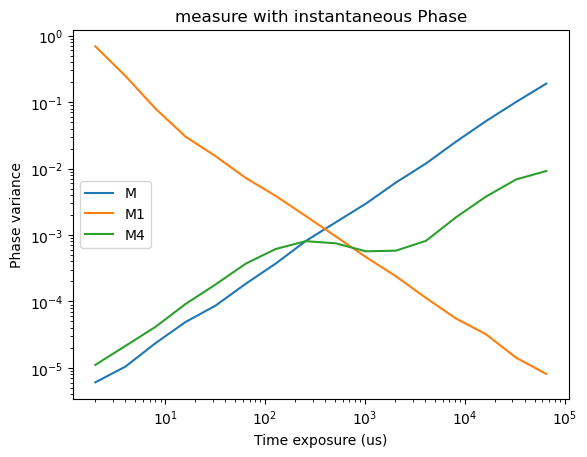

In [49]:
RAND_NUM=800 # 随机模拟次数
phase_l_dirc=np.zeros_like(time_exposure_list,dtype=float)
phase_m1_l_dirc=np.zeros_like(time_exposure_list,dtype=float)
phase_m4_l_dirc=np.zeros_like(time_exposure_list,dtype=float)
phase_m4_1_l_dirc=np.zeros_like(time_exposure_list,dtype=float)
phase_m4_2_l_dirc=np.zeros_like(time_exposure_list,dtype=float)
for j,time_exposure in enumerate(time_exposure_list):
    time_axis=np.arange(0,time_exposure,1) #1us分辨率，len=1s  SR=1M
    RAND_SEED=2025
    phase_end=np.zeros(RAND_NUM)
    M1_measure=np.zeros(RAND_NUM)
    M4_measure=np.zeros(RAND_NUM)
    M4_measure_1=np.zeros(RAND_NUM)
    M4_measure_2=np.zeros(RAND_NUM)
    for i in range(RAND_NUM):
        rng=np.random.default_rng(RAND_SEED+i)
        phase_speed=rng.normal(0,PHASE_SEEPD,time_axis.shape)
        # phase_speed[0]=0
        sig_ch1=get_sig_from_speed(phase_speed,1)
        sig_ch2=get_sig_from_speed(phase_speed,2)

        phase_M=np.cumsum(phase_speed)
        # sig_ch1_exposure=get_sig_from_phase(phase_M,1)
        # sig_ch2_exposure=get_sig_from_phase(phase_M,2)
        # ###引入shot noise
        # ch1_measure=rng.poisson(sig_ch1_exposure).sum()
        # ch2_measure=rng.poisson(sig_ch2_exposure).sum()

        sig_ch1_exposure=SIG_AMP*(GAMMY+np.sin(phase_M[-1]))*time_exposure
        sig_ch2_exposure=SIG_AMP*(GAMMY-np.sin(phase_M[-1]))*time_exposure
        ###引入shot noise
        ch1_measure=rng.poisson(sig_ch1_exposure)
        ch2_measure=rng.poisson(sig_ch2_exposure)


        phase_measure_M=get_phase_from_count(ch1_measure,ch2_measure)
        c0=fb_weight(phase_measure_M,time_exposure,sigma=1)
        c1=fb_weight(phase_measure_M,time_exposure,sigma=0.1)
        c2=fb_weight(phase_measure_M,time_exposure,sigma=2)
        phase_fb_M=np.sign(phase_measure_M)*np.abs(c0)
        
        phase_end[i]=phase_M[-1]
        M1_measure[i]=phase_measure_M
        M4_measure[i]=phase_fb_M
        M4_measure_1[i]=np.sign(phase_measure_M)*np.abs(c1)
        M4_measure_2[i]=np.sign(phase_measure_M)*np.abs(c2)

    phase_l_dirc[j]=np.var(phase_end)
    # phase_end=0
    phase_m1_l_dirc[j]=np.var(M1_measure-phase_end)
    phase_m4_l_dirc[j]=np.var(M4_measure-phase_end)
    phase_m4_1_l_dirc[j]=np.var(M4_measure_1-phase_end)
    phase_m4_2_l_dirc[j]=np.var(M4_measure_2-phase_end)

plt.plot(time_exposure_list,phase_l_dirc,label='M')
plt.plot(time_exposure_list,phase_m1_l_dirc,label='M1')
plt.plot(time_exposure_list,phase_m4_l_dirc,label='M4')
# plt.plot(time_exposure_list,phase_m4_1_l_dirc,label='M4_0.1_sigma')
# plt.plot(time_exposure_list,phase_m4_2_l_dirc,label='M4_2_sigam')
plt.title('measure with instantaneous Phase')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time exposure (us)')
plt.ylabel('Phase variance')

## 测量相位来自于测量时间的积分

Text(0, 0.5, 'Phase variance')

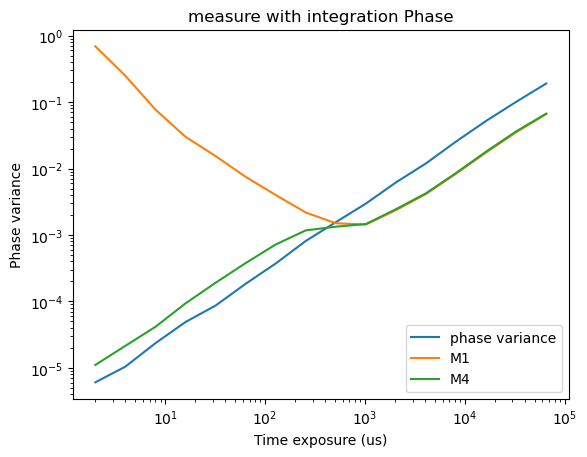

In [46]:
RAND_NUM=800 # 随机模拟次数
phase_l=np.zeros_like(time_exposure_list,dtype=float)
phase_m1_l=np.zeros_like(time_exposure_list,dtype=float)
phase_m4_l=np.zeros_like(time_exposure_list,dtype=float)
phase_m4_1_l=np.zeros_like(time_exposure_list,dtype=float)
phase_m4_2_l=np.zeros_like(time_exposure_list,dtype=float)
for j,time_exposure in enumerate(time_exposure_list):
    time_axis=np.arange(0,time_exposure,1) #1us分辨率，len=1s  SR=1M
    RAND_SEED=2025
    phase_end=np.zeros(RAND_NUM)
    M1_measure=np.zeros(RAND_NUM)
    M4_measure=np.zeros(RAND_NUM)
    M4_measure_1=np.zeros(RAND_NUM)
    M4_measure_2=np.zeros(RAND_NUM)
    for i in range(RAND_NUM):
        rng=np.random.default_rng(RAND_SEED+i)
        phase_speed=rng.normal(0,PHASE_SEEPD,time_axis.shape)
        # phase_speed[0]=0
        sig_ch1=get_sig_from_speed(phase_speed,1)
        sig_ch2=get_sig_from_speed(phase_speed,2)

        phase_M=np.cumsum(phase_speed)
        sig_ch1_exposure=get_sig_from_phase(phase_M,1)
        sig_ch2_exposure=get_sig_from_phase(phase_M,2)
        ###引入shot noise
        ch1_measure=rng.poisson(sig_ch1_exposure.sum())
        ch2_measure=rng.poisson(sig_ch2_exposure.sum())

        # sig_ch1_exposure=SIG_AMP*(GAMMY+np.sin(phase_M[-1]))*time_exposure
        # sig_ch2_exposure=SIG_AMP*(GAMMY-np.sin(phase_M[-1]))*time_exposure
        # ###引入shot noise
        # ch1_measure=rng.poisson(sig_ch1_exposure)
        # ch2_measure=rng.poisson(sig_ch2_exposure)


        phase_measure_M=get_phase_from_count(ch1_measure,ch2_measure)
        c0=fb_weight(phase_measure_M,time_exposure,sigma=1)
        c1=fb_weight(phase_measure_M,time_exposure,sigma=0.1)
        c2=fb_weight(phase_measure_M,time_exposure,sigma=2)
        phase_fb_M=np.sign(phase_measure_M)*np.abs(c0)
        
        phase_end[i]=phase_M[-1]
        M1_measure[i]=phase_measure_M
        M4_measure[i]=phase_fb_M
        M4_measure_1[i]=np.sign(phase_measure_M)*np.abs(c1)
        M4_measure_2[i]=np.sign(phase_measure_M)*np.abs(c2)

    phase_l[j]=np.var(phase_end)
    # phase_end=0
    phase_m1_l[j]=np.var(M1_measure-phase_end)
    phase_m4_l[j]=np.var(M4_measure-phase_end)
    phase_m4_1_l[j]=np.var(M4_measure_1-phase_end)
    phase_m4_2_l[j]=np.var(M4_measure_2-phase_end)

plt.plot(time_exposure_list,phase_l,label='phase variance')
plt.plot(time_exposure_list,phase_m1_l,label='M1')
plt.plot(time_exposure_list,phase_m4_l,label='M4')
# plt.plot(time_exposure_list,phase_m4_1_l,label='M4_0.1_sigma')
# plt.plot(time_exposure_list,phase_m4_2_l,label='M4_2_sigam')
plt.title('measure with integration Phase')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time exposure (us)')
plt.ylabel('Phase variance')

Text(0, 0.5, 'Phase variance')

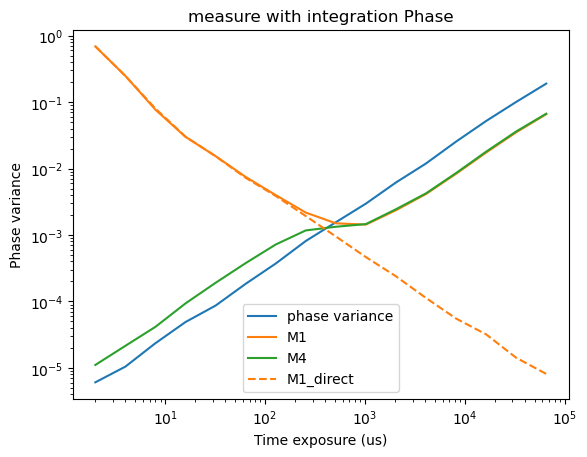

In [23]:
plt.plot(time_exposure_list,phase_l,label='phase variance')
plt.plot(time_exposure_list,phase_m1_l,label='M1')
plt.plot(time_exposure_list,phase_m4_l,label='M4')
# plt.plot(time_exposure_list,phase_m4_1_l,label='M4_0.1_sigma')
# plt.plot(time_exposure_list,phase_m4_2_l,label='M4_2_sigam')
plt.plot(time_exposure_list,phase_m1_l_dirc,label='M1_direct',color='C1',linestyle='--')
plt.title('measure with integration Phase')

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time exposure (us)')
plt.ylabel('Phase variance')

In [40]:
RAND_NUM=800 # 随机模拟次数
phase_l=np.zeros_like(time_exposure_list,dtype=float)
phase_m1_l=np.zeros_like(time_exposure_list,dtype=float)
phase_m4_l=np.zeros_like(time_exposure_list,dtype=float)
phase_m4_1_l=np.zeros_like(time_exposure_list,dtype=float)
phase_m4_2_l=np.zeros_like(time_exposure_list,dtype=float)
for j,time_exposure in enumerate([80]):
    time_axis=np.arange(0,time_exposure,1) #1us分辨率，len=1s  SR=1M
    RAND_SEED=2025
    phase_end=np.zeros(RAND_NUM)
    M1_measure=np.zeros(RAND_NUM)
    M4_measure=np.zeros(RAND_NUM)
    M4_measure_1=np.zeros(RAND_NUM)
    M4_measure_2=np.zeros(RAND_NUM)
    for i in range(RAND_NUM):
        rng=np.random.default_rng(RAND_SEED+i)
        phase_speed=rng.normal(0,PHASE_SEEPD,time_axis.shape)
        # phase_speed[0]=0
        sig_ch1=get_sig_from_speed(phase_speed,1)
        sig_ch2=get_sig_from_speed(phase_speed,2)

        phase_M=np.cumsum(phase_speed)
        sig_ch1_exposure=get_sig_from_phase(phase_M,1)
        sig_ch2_exposure=get_sig_from_phase(phase_M,2)
        ###引入shot noise
        ch1_measure=rng.poisson(sig_ch1_exposure.sum())
        ch2_measure=rng.poisson(sig_ch2_exposure.sum())

        # sig_ch1_exposure=SIG_AMP*(GAMMY+np.sin(phase_M[-1]))*time_exposure
        # sig_ch2_exposure=SIG_AMP*(GAMMY-np.sin(phase_M[-1]))*time_exposure
        # ###引入shot noise
        # ch1_measure=rng.poisson(sig_ch1_exposure)
        # ch2_measure=rng.poisson(sig_ch2_exposure)


        phase_measure_M=get_phase_from_count(ch1_measure,ch2_measure)
        c0=fb_weight(phase_measure_M,time_exposure,sigma=1)
        c1=fb_weight(phase_measure_M,time_exposure,sigma=0.1)
        c2=fb_weight(phase_measure_M,time_exposure,sigma=2)
        phase_fb_M=np.sign(phase_measure_M)*np.abs(c0)
        
        phase_end[i]=phase_M[-1]
        M1_measure[i]=phase_measure_M
        M4_measure[i]=phase_fb_M
        M4_measure_1[i]=np.sign(phase_measure_M)*np.abs(c1)
        M4_measure_2[i]=np.sign(phase_measure_M)*np.abs(c2)

    phase_l[j]=np.var(phase_end)
    phase_m1_l[j]=np.var(M1_measure-phase_end)
    phase_m4_l[j]=np.var(M4_measure-phase_end)
    phase_m4_1_l[j]=np.var(M4_measure_1-phase_end)
    phase_m4_2_l[j]=np.var(M4_measure_2-phase_end)

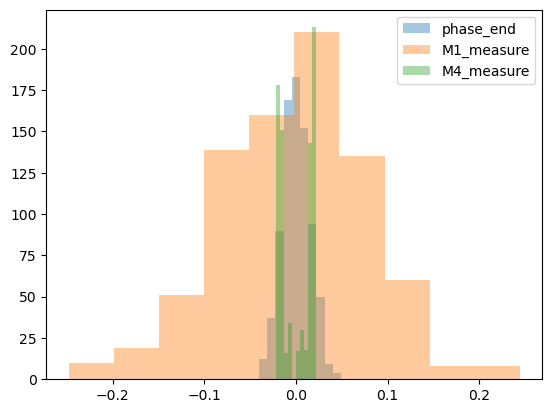

In [41]:
plt.hist(phase_end,label='phase_end',alpha=0.4)
plt.hist(M1_measure,label='M1_measure',alpha=0.4)
plt.hist(M4_measure,label='M4_measure',alpha=0.4)
plt.legend()


### 模拟 FISHER 信息

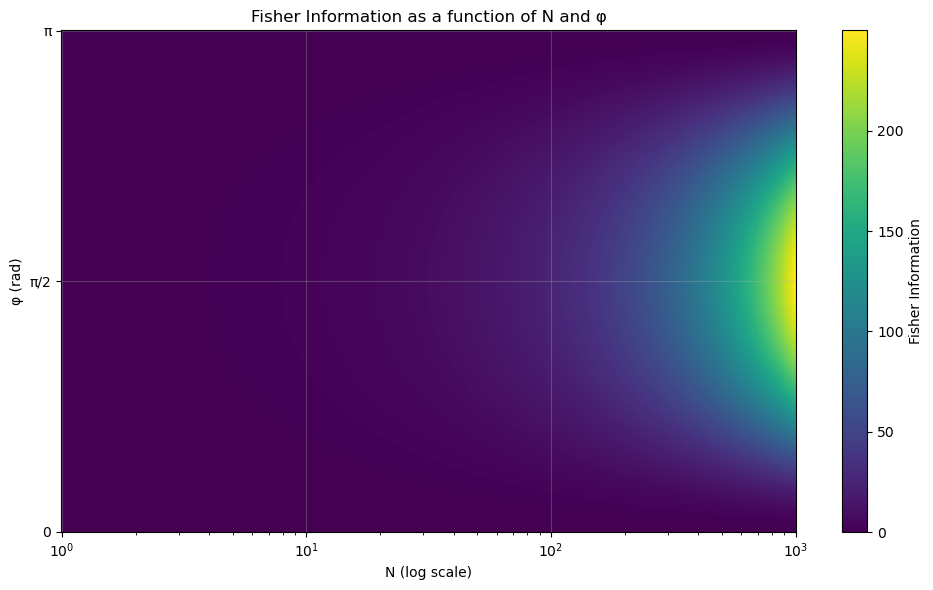

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# 定义Fisher信息函数
def func_fisher(N, phi):
    V = 0.5
    return (N * V * V * np.sin(phi) * np.sin(phi)) / (1 - V * V * np.cos(phi) * np.cos(phi))

# 创建N和phi的网格数据
# N的范围（可以根据需要调整）
N_min, N_max = 1, 1e3
N_points = 500
Ns = np.logspace(np.log10(N_min), np.log10(N_max), N_points)

# phi的范围（0到2π）
phi_min, phi_max = 0, np.pi
phi_points = 1000
phis = np.linspace(phi_min, phi_max, phi_points)

# 创建网格
N_grid, phi_grid = np.meshgrid(Ns, phis)

# 计算Fisher信息值
fisher_values = func_fisher(N_grid, phi_grid)

# 绘制二维热图
plt.figure(figsize=(10, 6))

# 使用pcolormesh绘制热图，使用对数坐标表示N
# 由于N是对数分布的，我们可以直接使用pcolormesh
mesh = plt.pcolormesh(Ns, phis, fisher_values, shading='auto')#, norm=LogNorm())

# 添加颜色条并设置标签
cbar = plt.colorbar(mesh)
cbar.set_label('Fisher Information')

# 设置x轴为对数坐标
plt.xscale('log')

# 添加标题和轴标签
plt.title('Fisher Information as a function of N and φ')
plt.xlabel('N (log scale)')
plt.ylabel('φ (rad)')

# 设置y轴刻度为π的倍数
plt.yticks([0, np.pi/2, np.pi],
           ['0', 'π/2', 'π'])

# 添加网格线
plt.grid(True, alpha=0.3)

# 显示图形
plt.tight_layout()
plt.show()


In [ ]:
tau_l=np.logspace(np.log10(1),np.log10(1e5),100)
RAND_NUM=100
fisher_array=np.zeros((tau_l.shape[0],RAND_NUM))
for _i,tau in enumerate(tau_l):
    rng=np.rand
    N=SIG_AMP*tau
    phi=np.
    fisher_array[_i]=


array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+01, 1.29154967e+01, 1.45082878e+01,
       1.62975083e+01, 1.83073828e+01, 2.05651231e+01, 2.31012970e+01,
       2.59502421e+01, 2.91505306e+01, 3.27454916e+01, 3.67837977e+01,
       4.13201240e+01, 4.64158883e+01, 5.21400829e+01, 5.85702082e+01,
       6.57933225e+01, 7.39072203e+01, 8.30217568e+01, 9.32603347e+01,
       1.04761575e+02, 1.17681195e+02, 1.32194115e+02, 1.48496826e+02,
       1.66810054e+02, 1.87381742e+02, 2.10490414e+02, 2.36448941e+02,
       2.65608778e+02, 2.98364724e+02, 3.35160265e+02, 3.76493581e+02,
       4.22924287e+02, 4.75081016e+02, 5.33669923e+02, 5.99484250e+02,
      